# Predicting Insurance Costs

In this project the total medical cost should be predicted using linear regression. The dataset can be found [here](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=download) and contains information on individual medical insurance bills. Each bill is associated with some demographic and personal characteristics of the person who received it.
These features about the patient should be used to predict the cost.

First the relevant libraries are import and the dataset is read in:

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Exploring the Dataset

Information about the different features seems obvious to the author and is not elaborated upon further. However, it can be observed [here](https://www.kaggle.com/datasets/mirichoi0218/insurance?resource=downloa).

In [2]:
df.shape

(1338, 7)

The dataset consis of `1338` observations and `7` features.

In [3]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

There are no missing values in the dataset.

In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


The target variable `charges` is right-skewed indicating there are some outliers in the high range of charges.

In [5]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

The dataset consists of numerical and categorical (`sex`, `smoker` and `region`) features. `sex` will be encoded with `male` = `1` and `female`= `0`. `smoker` will be encoded by `1` for `yes` and `0` for `no`:

In [6]:
df['sex'] = df['sex'].map({'male':1,'female':0})
df['smoker'] = df['smoker'].map({'yes':1,'no':0})

The `region` features has to be encoded using dummy variables:

In [7]:
dummies = pd.get_dummies(df['region'])
df = pd.concat([df,dummies],axis=1)
df.drop(labels='region', axis=1, inplace=True)

The *pearson* correlation between the features and the target variable (and also between the features themselves) is given by: 

<AxesSubplot:>

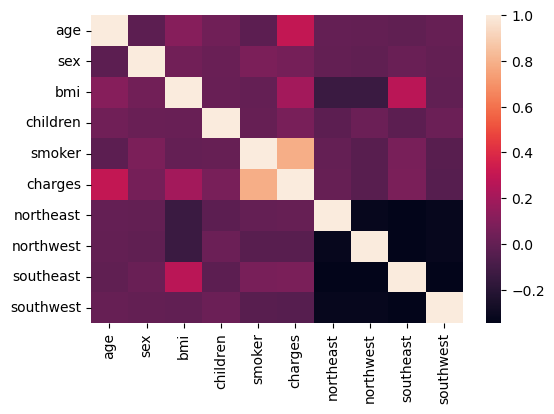

In [8]:
pearsons = df.corr()
plt.figure(figsize=(6,4))
sns.heatmap(pearsons)

A better observability is given by restricting the output to a threshold of `0.15`:

<AxesSubplot:>

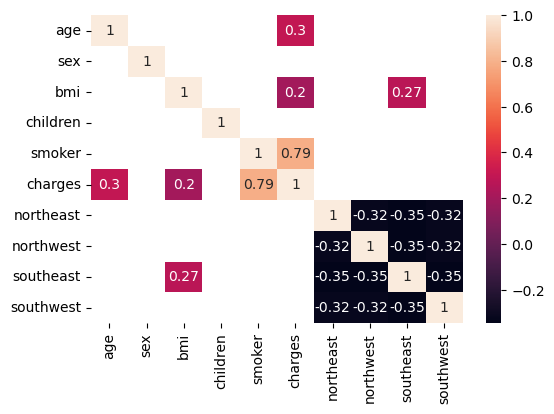

In [9]:
plt.figure(figsize=(6,4))
sns.heatmap(pearsons[abs(pearsons) > 0.15],annot=True)

The target variable `charges` is highly correlated to `smoker` and moderately correlated to `age` and `bmi`.
The `region` dummy variables are (obviously) negatively correlated. `bmi` is correlated with `southeast`.

### Feature Selection and Dividing the Data

Based on the findings above the features `age`, `bmi` and `smoker` will be selected for training the model. For validation also a test subset of this data is necessary. The dividing of the dataset will be performed in the following yielding a test set with `20%` of the original dataset:

In [10]:
X = df[['age','bmi','smoker']]
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Building the Model

Now the model is built and fitted:

In [11]:
model = LinearRegression()
model.fit(X_train,y_train)

model.coef_

array([  259.41020462,   326.45023215, 23675.37184666])

The optimized coefficients meet the expected behaviour of the analysis of the correlations. E.g.: a increase of one year of `age` yields for an increase of `259.4 $` in `charges` (controlling for `bmi` and `smoker`). The change of the average in `charges` is significant controlling for `age` and `bmi` and changing from non-smoker to smoker (`23675.4 $`).

The coefficient of determination yields a score of `0.74`:

In [12]:
y_pred = model.predict(X_train)
r2_score(y_train, y_pred)

0.7392286795956207

The mean squared error yields: 

In [13]:
mean_squared_error(y_train, y_pred, squared = False)

6134.9872999260115

In [14]:
residuals = y_train - y_pred
residuals.mean()

-1.992388393416583e-12

The mean of the residuals is approximately `0` indicating the predictors are unbiased. The residuals plot however shows that the variance of the residuals is not constant: 

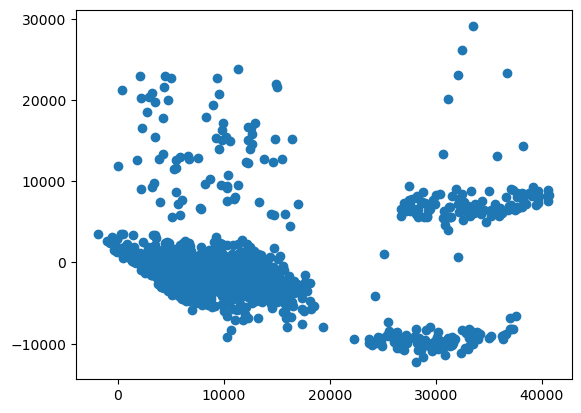

In [15]:
plt.scatter(y_pred, residuals)
plt.show()

<AxesSubplot:>

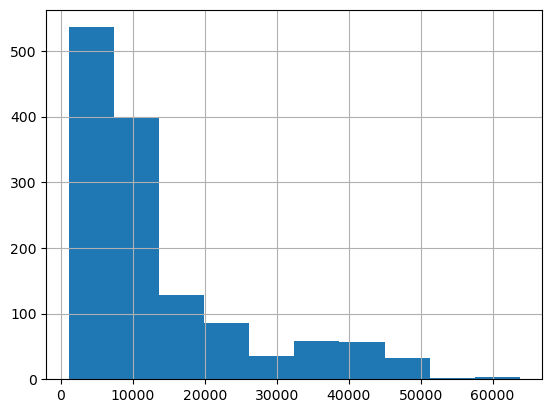

In [16]:
df['charges'].hist()

In [17]:
X = df[['age','bmi','smoker']]
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_test_log = np.log2(y_test)
y_train_log = np.log2(y_train)

model = LinearRegression()
model.fit(X_train,y_train_log)

y_pred = model.predict(X_train)

In [18]:
r2_score(y_train_log, y_pred)

0.737066139753993

In [19]:
np.exp(mean_squared_error(y_train_log, y_pred, squared = False))

1.9621898738979213

In [20]:
residuals = y_train_log - y_pred

residuals.mean()

-1.494131920990865e-17

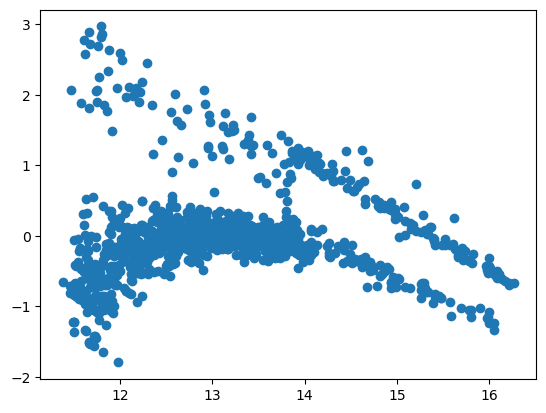

In [21]:
plt.scatter(y_pred, residuals)
plt.show()

There seems to be a polynomial trend. However, the residuals plot seems to be better. 

### Final Model Evalaluation

Now the model is tested on the test data:

In [22]:
y_pred = model.predict(X_test)
r2_score(y_test_log, y_pred)

0.7704945422014753

In [23]:
np.exp(mean_squared_error(y_test_log, y_pred, squared = False))

1.9258500405115686

In [25]:
residuals = y_test_log - y_pred

residuals.mean()

-0.06706769795368424

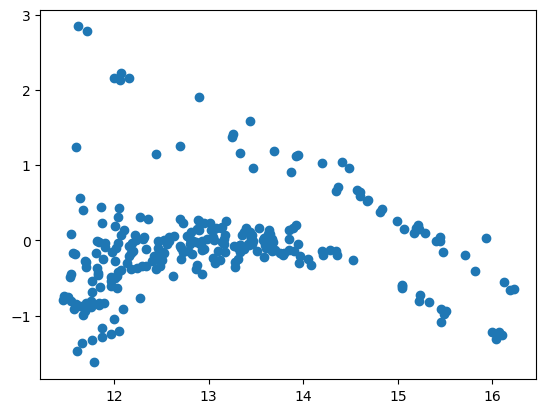

In [26]:
plt.scatter(y_pred, residuals)
plt.show()